In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import datetime as dt
from operator import attrgetter

plt.style.use('ggplot')

In [178]:
df = pd.read_csv('supermarket.csv')
df.tail(3)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,...,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
578079,200637,20061109,5,16,1,4.47,PRD0900396,CL00229,DEP00081,G00027,...,UM,NaN,994103100229855,L,MM,Full Shop,Mixed,STORE00001,LS,E02
578080,200717,20070624,1,10,1,4.92,PRD0903065,CL00229,DEP00081,G00027,...,UM,YF,994106300437841,L,MM,Full Shop,Mixed,STORE00001,LS,E02
578081,200744,20071229,7,14,1,9.27,PRD0901923,CL00229,DEP00081,G00027,...,UM,NaN,994109000359411,L,MM,Top Up,Mixed,STORE00001,LS,E02


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578082 entries, 0 to 578081
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SHOP_WEEK                 578082 non-null  int64  
 1   SHOP_DATE                 578082 non-null  int64  
 2   SHOP_WEEKDAY              578082 non-null  int64  
 3   SHOP_HOUR                 578082 non-null  int64  
 4   QUANTITY                  578082 non-null  int64  
 5   SPEND                     578082 non-null  float64
 6   PROD_CODE                 578082 non-null  object 
 7   PROD_CODE_10              578082 non-null  object 
 8   PROD_CODE_20              578082 non-null  object 
 9   PROD_CODE_30              578082 non-null  object 
 10  PROD_CODE_40              578082 non-null  object 
 11  CUST_CODE                 492494 non-null  object 
 12  CUST_PRICE_SENSITIVITY    492494 non-null  object 
 13  CUST_LIFESTAGE            433142 non-null  o

In [180]:
# Found missing values on CUST_CODE, CUST_PRICE_SENSITIVITY, CUST_LIFESTAGE columns
df.isna().sum()

SHOP_WEEK                        0
SHOP_DATE                        0
SHOP_WEEKDAY                     0
SHOP_HOUR                        0
QUANTITY                         0
SPEND                            0
PROD_CODE                        0
PROD_CODE_10                     0
PROD_CODE_20                     0
PROD_CODE_30                     0
PROD_CODE_40                     0
CUST_CODE                    85588
CUST_PRICE_SENSITIVITY       85588
CUST_LIFESTAGE              144940
BASKET_ID                        0
BASKET_SIZE                      0
BASKET_PRICE_SENSITIVITY         0
BASKET_TYPE                      0
BASKET_DOMINANT_MISSION          0
STORE_CODE                       0
STORE_FORMAT                     0
STORE_REGION                     0
dtype: int64

In [181]:
# Clean missing values
df.dropna(subset=['CUST_CODE'], inplace=True)
df['CUST_LIFESTAGE'] = df['CUST_LIFESTAGE'].fillna('XX')
df.isna().sum()

SHOP_WEEK                   0
SHOP_DATE                   0
SHOP_WEEKDAY                0
SHOP_HOUR                   0
QUANTITY                    0
SPEND                       0
PROD_CODE                   0
PROD_CODE_10                0
PROD_CODE_20                0
PROD_CODE_30                0
PROD_CODE_40                0
CUST_CODE                   0
CUST_PRICE_SENSITIVITY      0
CUST_LIFESTAGE              0
BASKET_ID                   0
BASKET_SIZE                 0
BASKET_PRICE_SENSITIVITY    0
BASKET_TYPE                 0
BASKET_DOMINANT_MISSION     0
STORE_CODE                  0
STORE_FORMAT                0
STORE_REGION                0
dtype: int64

In [182]:
df['SHOP_DATE'] = pd.to_datetime(df['SHOP_DATE'], format='%Y%m%d')
# df['SHOP_MONTH'] = df['SHOP_DATE'].dt.to_period('m')
# df.loc[:,['SHOP_DATE','SHOP_MONTH']].tail(3)

In [183]:
df[['QUANTITY', 'SPEND']].describe().apply(lambda x: x.apply('{0:.5f}'.format)).transpose()

,count,mean,std,min,25%,50%,75%,max
QUANTITY,492494.00000,1.52764,1.57281,1.00000,1.00000,1.00000,1.00000,129.00000
SPEND,492494.00000,1.92788,2.69127,0.01000,0.77000,1.24000,2.11000,346.46000


### EDA

In [184]:
n_basket = df.groupby(['CUST_CODE'])['BASKET_ID'].nunique()
mult_orders_perc = np.sum(n_basket > 1) / df['CUST_CODE'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

70.25% of customers ordered more than once.


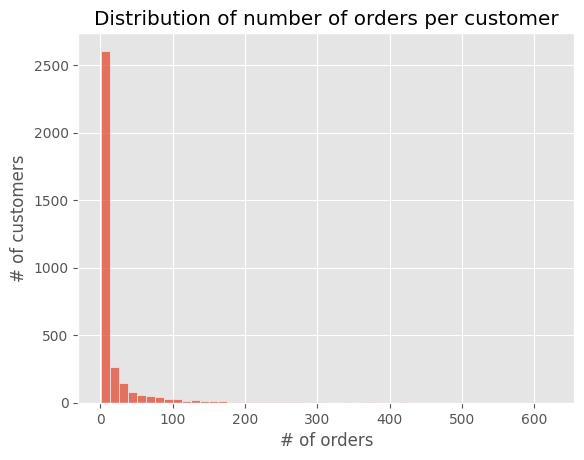

In [185]:
ax = sns.histplot(n_basket, bins=50)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers')
plt.show()

### Cohort Analysis

In [196]:
df_cohort = df.copy()
df_cohort = df_cohort[['CUST_CODE', 'BASKET_ID', 'SHOP_DATE']].drop_duplicates()
df_cohort.tail(3)

,CUST_CODE,BASKET_ID,SHOP_DATE
577882,CUST0000392892,994110600422860,2008-04-14
577973,CUST0000335064,994110700385959,2008-04-25
578057,CUST0000259310,994110100339567,2008-03-12


In [197]:
df_cohort['SHOP_MONTH'] = df_cohort['SHOP_DATE'].dt.to_period('M')
df_cohort['cohort'] = df_cohort.groupby('CUST_CODE')['SHOP_DATE'] \
                 .transform('min') \
                 .dt.to_period('M')
df_cohort.tail(3)

,CUST_CODE,BASKET_ID,SHOP_DATE,SHOP_MONTH,cohort
577882,CUST0000392892,994110600422860,2008-04-14,2008-04,2006-05
577973,CUST0000335064,994110700385959,2008-04-25,2008-04,2006-04
578057,CUST0000259310,994110100339567,2008-03-12,2008-03,2008-03


In [198]:
df_cohort = df_cohort.groupby(['cohort', 'SHOP_MONTH']) \
              .agg(n_customers=('CUST_CODE', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.SHOP_MONTH - df_cohort.cohort).apply(attrgetter('n'))
df_cohort.tail(3)

,cohort,SHOP_MONTH,n_customers,period_number
392,2008-03,2008-06,4,3
393,2008-03,2008-07,1,4
394,2008-04,2008-04,15,0


In [199]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_pivot.tail(3)

period_number,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
cohort,,,,,,,,,,,,,,,,,,,,,
2008-02,65.0,11.0,6.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-03,71.0,7.0,3.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [216]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix.tail(3)

period_number,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
cohort,,,,,,,,,,,,,,,,,,,,,
2008-02,1.0,0.169231,0.092308,0.092308,0.061538,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-03,1.0,0.098592,0.042254,0.056338,0.014085,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


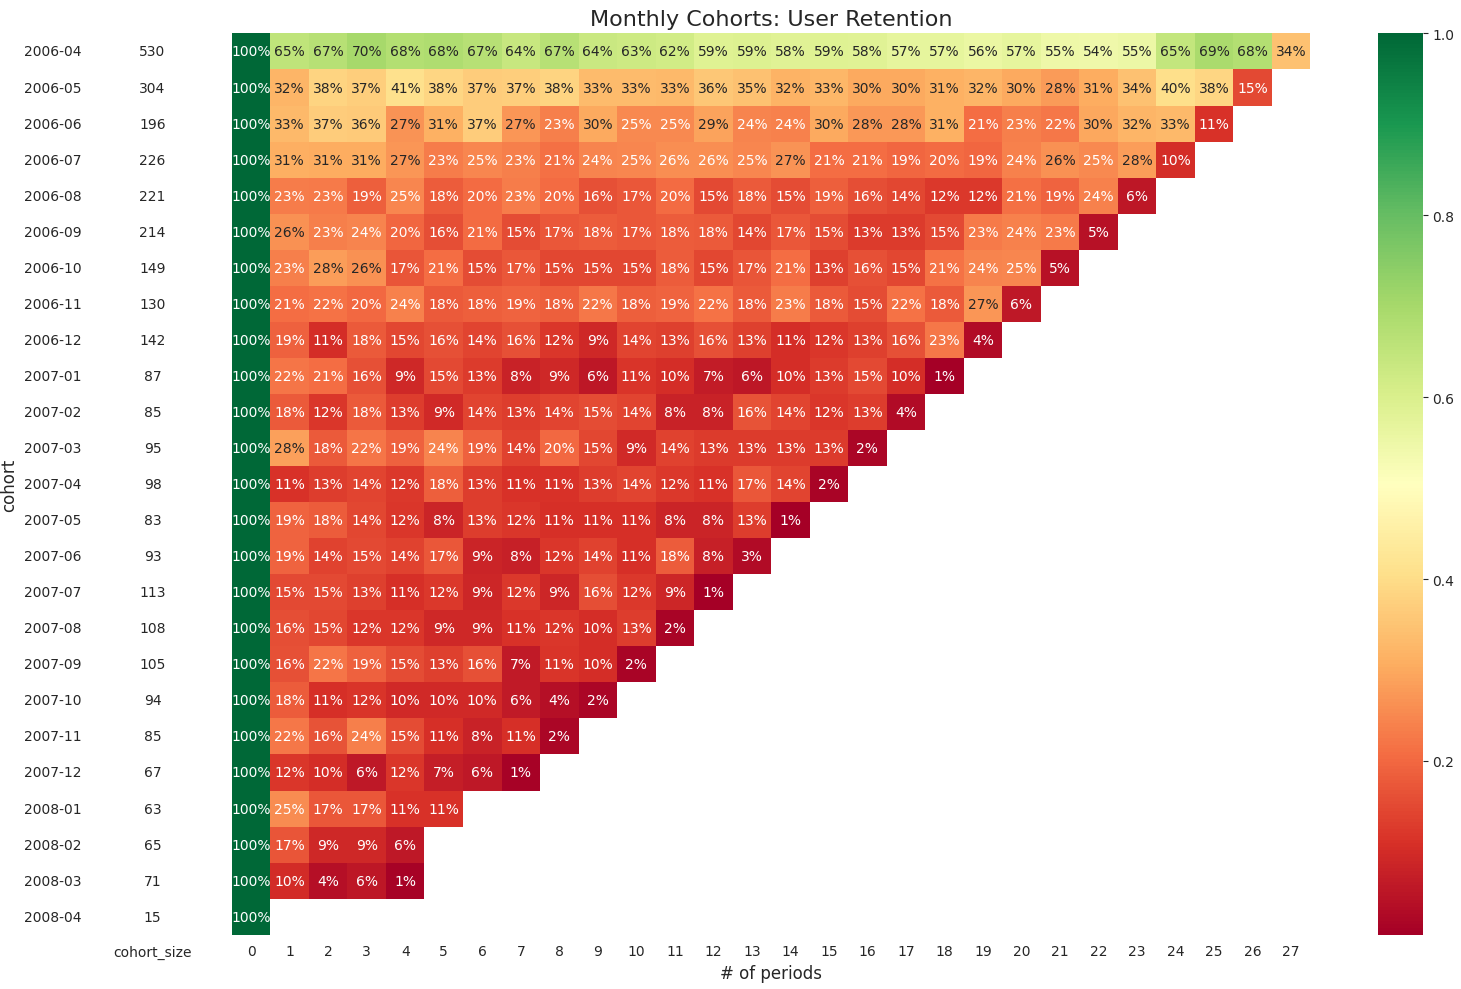

In [210]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 10), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()